# **CS 4361/5361 Machine Learning**
**Practice Exam 2**

## **Question 1**

Instead of using pixel values, we will classify the MNIST dataset using as features the sums of the rows and columns of the images. That is, each image will be represented by 56 attributes: the sum of its 28 rows and the sum of its 28 columns.

For example, suppose we have a 4-by-4 image as shown below (the green boxes). Then we could represent the image by the 8 attributes included in the yellow boxes ([3.00, 1.75, 4.25, 5.75, 6.00, 0.50, 5.00, 3.25]); with the first 4 elements representing the mean internsity of every column and the last 4 representing the mean intensities of every row.

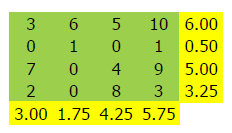

Write a function that extacts the features described above.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
def mean_rows_cols(X):
  return np.hstack((np.mean(X,axis=1),np.mean(X,axis=2)))

In [5]:
x_test_s = mean_rows_cols(np.float32(x_test)/255)
x_train_s = mean_rows_cols(np.float32(x_train)/255)
print(x_train_s.shape)
print(x_test_s.shape)

(60000, 56)
(10000, 56)


In [6]:
model = SVC()
model.fit(x_train_s, y_train)
pred = model.predict(x_test_s)
accuracy = accuracy_score(y_test, pred)
print(f'Accuracy {accuracy:.4}')
print(confusion_matrix(y_test, pred))

Accuracy 0.9086
[[ 949    5    4    0    1    4    5    3    9    0]
 [   0 1105    3    1    3    1    5    0   16    1]
 [   7    1  926   27    6   32   21    7    5    0]
 [   1   10   28  875    3   39    0   27   21    6]
 [   2    2    3    0  929    0    2    1    2   41]
 [  12    7   40   92    5  681    5   19   24    7]
 [   5    7   20    1    4    5  907    0    9    0]
 [   2   16   10    6   11    7    0  929   12   35]
 [  15   18    0   13    6   12   12   13  872   13]
 [   6   11    0   10   38    5    0   12   14  913]]


In [7]:
pca = PCA(n_components=10).fit(x_train_s)
x_train_pca = pca.transform(x_train_s)
x_test_pca = pca.transform(x_test_s)
model = SVC()
model.fit(x_train_pca, y_train)
pred = model.predict(x_test_pca)
accuracy = accuracy_score(y_test, pred)
print(f'Accuracy {accuracy:.4}')
print(confusion_matrix(y_test, pred))

Accuracy 0.8904
[[ 951    6    3    0    0    5    2    3    9    1]
 [   5 1091    2    3    4    1    6    2   20    1]
 [   4    2  915   37    4   32   23    9    5    1]
 [   1    9   32  841    1   52    0   26   35   13]
 [   2    3    4    0  912    2    2    1    2   54]
 [  15    6   39   93    2  652    6   24   43   12]
 [   5    6   20    0    5    4  904    0   14    0]
 [   3   15   12   14    9   10    0  908   15   42]
 [  16   27    2   21    2   29   11   13  838   15]
 [   5   12    0    9   49    6    0   12   24  892]]


Write a function that classifies the MNIST dataset using the feautures described above using a dense neural network with 2 hidden layers with 56 units each, implemented in Keras. 

In [8]:
from keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from keras.utils.vis_utils import plot_model

In [20]:
def plot_results(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  fig, ax = plt.subplots()
  ax.plot(accuracy,label = 'train')
  ax.plot(val_accuracy,label = 'test')
  ax.set_title('Accuracy')
  ax.legend(loc='lower right')
  fig, ax = plt.subplots()
  ax.plot(loss,label = 'train')
  ax.plot(val_loss,label = 'test')
  ax.set_title('Loss')
  ax.legend(loc='upper right')
  plt.show()

In [9]:
def dense_model(inputs = 56,hidden_1=56, hidden_2=56):
  model = tf.keras.models.Sequential()
  model.add(Dense(hidden_1, input_shape=(inputs,), activation='relu'))
  model.add(Dense(hidden_2, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

In [10]:
dense_network = dense_model()
dense_network.summary() 
dense_network.compile(loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                3192      
                                                                 
 dense_1 (Dense)             (None, 56)                3192      
                                                                 
 dense_2 (Dense)             (None, 10)                570       
                                                                 
Total params: 6,954
Trainable params: 6,954
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Convert y to one-hot
y_train_oh = tf.keras.utils.to_categorical(y_train, 10)
y_test_oh = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
history = dense_network.fit(
    x_train_s, y_train_oh,
    epochs =  100, 
    batch_size=256, 
    verbose = 1,
    validation_data=(x_test_s, y_test_oh),
)

Training accuracy 0.9301
Test accuracy 0.9099


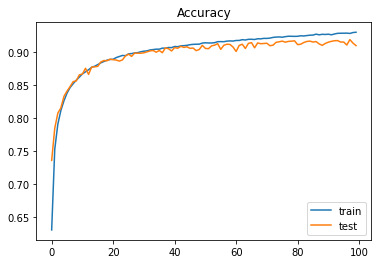

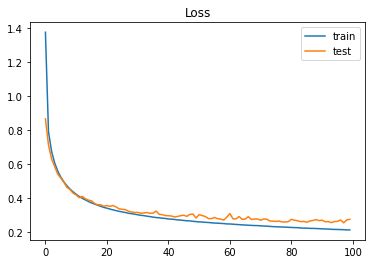

In [21]:
train_accuracy = history.history['accuracy'][-1]
test_accuracy = history.history['val_accuracy'][-1]
print(f'Training accuracy {train_accuracy:.4}')
print(f'Test accuracy {test_accuracy:.4}')
plot_results(history)

## **Question 2**

The following code implements a vgg-style network to classify the CIFAR-10 dataset. 

Evaluate the effects of each of the following changes to the original architecture. 

*   Removing the dense layer before the classification layer. 
*   Replacing the max pooling operators by convolutions with a 2-by-2 stride. 
*   Decreasing the number of convolutional filters to half the original number in each layer. 
*   Increasing the size of convolution kernels to twice their original size (in each dimension).


### **Original program**

In [22]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = np.float32(x_train)/255
x_test = np.float32(x_test)/255

# Convert y to one-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

170508288/170498071 [==============================] - 25s 0us/step


In [23]:
def vgg3(input_shape=(32,32,3)):
  model = tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same', activation="relu"))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

In [24]:
cnn = vgg3(input_shape= x_train.shape[1:])
cnn.summary() 
cnn.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    
history = cnn.fit(
    x_train, y_train,
    epochs =  30, 
    batch_size=256, 
    verbose = 1,
    validation_data=(x_test, y_test),
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [ ]:
print('Final accuracy on training set: {:.4f}'.format(history.history['accuracy'][-1]))
print('Final accuracy on test set: {:.4f}'.format(history.history['val_accuracy'][-1]))
print('Mean accuracy in last 5 epochs: {:.4f}'.format(np.mean(history.history['val_accuracy'][-5:])))

plot_results(history)

### **Replacing the max pooling operators by convolutions with a 2-by-2 stride.**

In [34]:
def vgg3(input_shape=(32,32,3)):
  model = tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same', activation="relu"))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(Conv2D(32, kernel_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, kernel_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(128, kernel_size=(2, 2), strides=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

In [35]:
cnn = vgg3(input_shape= x_train.shape[1:])
cnn.summary() 
cnn.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    
history = cnn.fit(
    x_train, y_train,
    epochs =  30, 
    batch_size=256, 
    verbose = 1,
    validation_data=(x_test, y_test),
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_39 (Conv2D)          (None, 16, 16, 32)        4128      
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 conv2d_42 (Conv2D)          (None, 8, 8, 64)          16448     
                                                                 
 conv2d_43 (Conv2D)          (None, 8, 8, 128)        

Final accuracy on training set: 0.9785
Final accuracy on test set: 0.7206
Mean accuracy in last 5 epochs: 0.7353


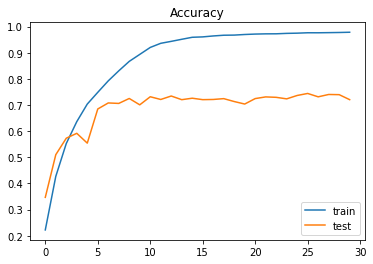

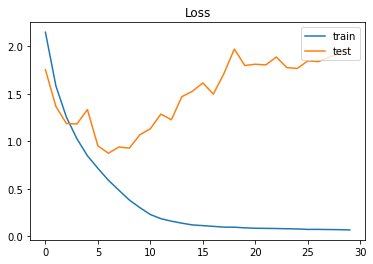

In [36]:
print('Final accuracy on training set: {:.4f}'.format(history.history['accuracy'][-1]))
print('Final accuracy on test set: {:.4f}'.format(history.history['val_accuracy'][-1]))
print('Mean accuracy in last 5 epochs: {:.4f}'.format(np.mean(history.history['val_accuracy'][-5:])))

plot_results(history)

### **Removing the dense layer before the classification layer.**

In [37]:
def vgg3(input_shape=(32,32,3)):
  model = tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same', activation="relu"))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(10, activation='softmax'))
  return model

In [39]:
cnn = vgg3(input_shape= x_train.shape[1:])
cnn.summary() 
cnn.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    
history = cnn.fit(
    x_train, y_train,
    epochs =  30, 
    batch_size=256, 
    verbose = 1,
    validation_data=(x_test, y_test),
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_53 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_55 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

Final accuracy on training set: 0.9782
Final accuracy on test set: 0.7497
Mean accuracy in last 5 epochs: 0.7469


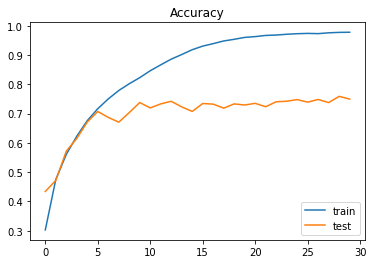

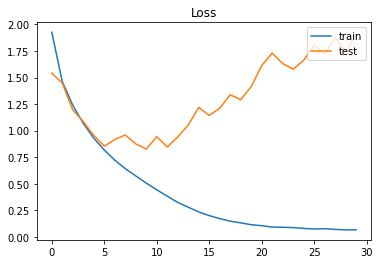

In [40]:
print('Final accuracy on training set: {:.4f}'.format(history.history['accuracy'][-1]))
print('Final accuracy on test set: {:.4f}'.format(history.history['val_accuracy'][-1]))
print('Mean accuracy in last 5 epochs: {:.4f}'.format(np.mean(history.history['val_accuracy'][-5:])))

plot_results(history)

### **Decreasing the number of convolutional filters to half the original number in each layer.**

In [41]:
def vgg3(input_shape=(32,32,3)):
  model = tf.keras.models.Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, padding='same', activation="relu"))
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation="relu"))
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

In [42]:
cnn = vgg3(input_shape= x_train.shape[1:])
cnn.summary() 
cnn.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    
history = cnn.fit(
    x_train, y_train,
    epochs =  30, 
    batch_size=256, 
    verbose = 1,
    validation_data=(x_test, y_test),
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 conv2d_61 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                 

Final accuracy on training set: 0.9666
Final accuracy on test set: 0.6966
Mean accuracy in last 5 epochs: 0.6979


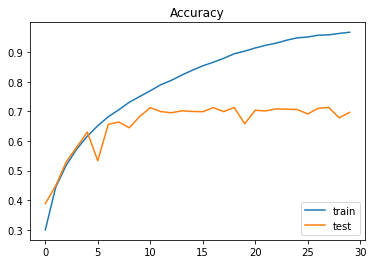

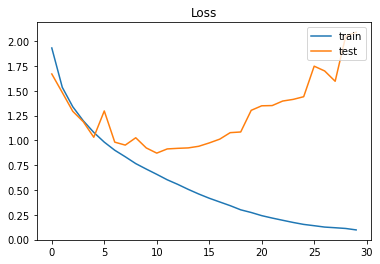

In [43]:
print('Final accuracy on training set: {:.4f}'.format(history.history['accuracy'][-1]))
print('Final accuracy on test set: {:.4f}'.format(history.history['val_accuracy'][-1]))
print('Mean accuracy in last 5 epochs: {:.4f}'.format(np.mean(history.history['val_accuracy'][-5:])))

plot_results(history)

### **Increasing the size of convolution kernels to twice their original size (in each dimension).**

In [44]:
def vgg3(input_shape=(32,32,3)):
  model = tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(6, 6), input_shape=input_shape, padding='same', activation="relu"))
  model.add(Conv2D(32, kernel_size=(6, 6), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, kernel_size=(6, 6), padding='same', activation="relu"))
  model.add(Conv2D(64, kernel_size=(6, 6), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, kernel_size=(6, 6), padding='same', activation="relu"))
  model.add(Conv2D(128, kernel_size=(6, 6), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

In [45]:
cnn = vgg3(input_shape= x_train.shape[1:])
cnn.summary() 
cnn.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    
history = cnn.fit(
    x_train, y_train,
    epochs =  30, 
    batch_size=256, 
    verbose = 1,
    validation_data=(x_test, y_test),
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 32, 32, 32)        3488      
                                                                 
 conv2d_65 (Conv2D)          (None, 32, 32, 32)        36896     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 16, 16, 64)        73792     
                                                                 
 conv2d_67 (Conv2D)          (None, 16, 16, 64)        147520    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                

Final accuracy on training set: 0.9451
Final accuracy on test set: 0.6896
Mean accuracy in last 5 epochs: 0.6959


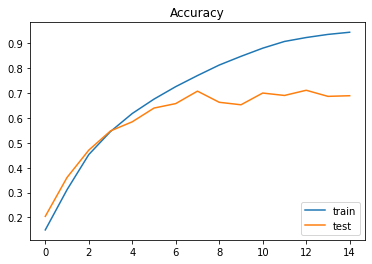

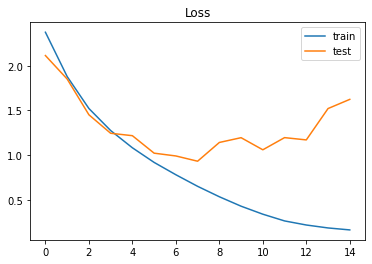

In [33]:
print('Final accuracy on training set: {:.4f}'.format(history.history['accuracy'][-1]))
print('Final accuracy on test set: {:.4f}'.format(history.history['val_accuracy'][-1]))
print('Mean accuracy in last 5 epochs: {:.4f}'.format(np.mean(history.history['val_accuracy'][-5:])))

plot_results(history)